## Random Forest Regression

<img src="figures/rf_intro.png" alt="mloverview" class="bg-primary" width="700px">

### Random Forest Tutorial Aims:

* Random Forest classification with scikit-learn
* How random forests work
* How to use them for regression
* How to evaluate their performance (& tune Hyper-parameters)


<img src="figures/rf_1.png" alt="mloverview" class="bg-primary" width="700px">


### Water level prediction in Baden-Württemberg

A typical machine learning approach consists of several steps that can be arranged in a kind of standard workflow. Training of the model, which we have done in the previous examples of different algorithms, is only a small part of this workflow. Data preprocessing and model evaluation and selection are by far the more extensive tasks. In the following we will walk through the entire workflow using a simple but more realistic example than using toy data. **We will build a Random Forest Regression as an Example for a typical ML workflow.**

Our goal is to use climate data (temperature and precipitation) and predict the daily mean water level at a water level monitoring station in Baden-Württemberg.

### Data Collection

For this example, we will use a daily time series from the water level (Pegel) stations in Baden-Württemberg (BW), downloadable from [UDO](https://udo.lubw.baden-wuerttemberg.de/public/processingChain?repositoryItemGlobalId=hydrologische_landespegel&conditionValuesSetHash=00E06F8&selector=hydrologische_landespegel&sourceOrderAsc=false&offset=0&limit=2147483647). The data provided here was downloaded on 2024-07-22. A detailed description of the variables is available [here](https://www.hvz.baden-wuerttemberg.de). For the purpose of this tutorial the dataset is provided in [here](data/Jagstzell_Jagst_dailyData_HYRAS_Pegelstand.csv).



<img src="figures/pegel_BW.png" width="800"/>


<img src="figures/ausgewählte_stations.png" width="400"/>


As for the respective climate data we use the [HYRAS Dataset (Hydrometeorologische Rasterdatensätze)](https://www.dwd.de/DE/leistungen/hyras/hyras.html) provided by the [Deutsche Wetterdienst DWD](https://www.dwd.de/DE/Home/home_node.html).
The respective data is open access and can be easily downloaded [here](https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/). The respective climate data at the water level monitoring station is already appended in the provided csv file.

### Read Data Set

In [1]:
%load_ext lab_black

In [2]:
# First, let's import all the needed libraries.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [6]:
os.getcwd()
os.chdir("..")
os.getcwd()

'/Users/marie-christineckert/Nextcloud/TU/ML_jupyter_reader/contents/ML_algorithms/5_Supervised'

In [63]:
data_raw = pd.read_csv(
    "data/Jagstzell_Jagst_dailyData_HYRAS_Pegelstand.csv",
    # sep=";",
    # na_values=["-999"],
    skipinitialspace=True,
)

data_raw = data_raw.drop(columns=["Unnamed: 0"])
data_raw.head(10)

,Date,pr,tas,Wert,Einheit,Produkt
0,1970-01-01 12:00:00,0.3,-5.6,NaN,NaN,NaN
1,1970-01-02 12:00:00,0.6,-3.7,NaN,NaN,NaN
2,1970-01-03 12:00:00,3.6,-0.5,NaN,NaN,NaN
3,1970-01-04 12:00:00,11.2,-0.4,NaN,NaN,NaN
4,1970-01-05 12:00:00,1.5,-2.5,NaN,NaN,NaN
5,1970-01-06 12:00:00,0.1,-3.0,NaN,NaN,NaN
6,1970-01-07 12:00:00,0.0,-1.5,NaN,NaN,NaN
7,1970-01-08 12:00:00,1.9,-4.1,NaN,NaN,NaN
8,1970-01-09 12:00:00,5.6,-1.5,NaN,NaN,NaN
9,1970-01-10 12:00:00,4.3,-0.4,NaN,NaN,NaN


The data set contains 18628 samples and the following 3 variables: 
pr, tas and Wert.

In [64]:
data_raw.dtypes

Date        object
pr         float64
tas        float64
Wert       float64
Einheit     object
Produkt     object
dtype: object

#### Remove unnecessary columns

By looking at the data and consulting the variable description, we can immediately find variables that are not useful for our purpose and drop them.
- Einheit
- Produkt

In [66]:
data = data_raw.drop(columns=["Einheit", "Produkt"])
data

,Date,pr,tas,Wert
0,1970-01-01 12:00:00,0.3,-5.6,NaN
1,1970-01-02 12:00:00,0.6,-3.7,NaN
2,1970-01-03 12:00:00,3.6,-0.5,NaN
3,1970-01-04 12:00:00,11.2,-0.4,NaN
4,1970-01-05 12:00:00,1.5,-2.5,NaN
...,...,...,...,...
18623,2020-12-27 12:00:00,23.6,1.7,36.0
18624,2020-12-28 12:00:00,6.5,2.5,32.0
18625,2020-12-29 12:00:00,1.9,1.7,32.0
18626,2020-12-30 12:00:00,0.2,2.4,28.0


#### Rename columns for convenience

To improve the readability, we rename the remaining columns.

In [67]:
data = data.rename(
    columns={
        "pr": "prec_sum",
        "tas": "temp_mean",
        "Wert": "water_level",
    }
)
data

,Date,prec_sum,temp_mean,water_level
0,1970-01-01 12:00:00,0.3,-5.6,NaN
1,1970-01-02 12:00:00,0.6,-3.7,NaN
2,1970-01-03 12:00:00,3.6,-0.5,NaN
3,1970-01-04 12:00:00,11.2,-0.4,NaN
4,1970-01-05 12:00:00,1.5,-2.5,NaN
...,...,...,...,...
18623,2020-12-27 12:00:00,23.6,1.7,36.0
18624,2020-12-28 12:00:00,6.5,2.5,32.0
18625,2020-12-29 12:00:00,1.9,1.7,32.0
18626,2020-12-30 12:00:00,0.2,2.4,28.0


####  Drop missing data

As a next step, we check the data for missing values.

In [68]:
data.isnull().sum()

Date              0
prec_sum          0
temp_mean         0
water_level    4292
dtype: int64

As we can see, the percentage of missing values in our data is quite high (4292 out of 18628 rows). Since we only have missings in the `water_level`column, we might conclude that our water level time series is significantly shorter than the climate data time series. Therefore, the simplest solution is to simply drop all rows with missing data. 


If our modelling goal was different, other solutions might be more useful, such as **imputing values** for the missing values ( we can even use a Random Forest for that!)

In [69]:
## check how many rows are empty from the beginning
first_row_not_na = data.water_level.notna().idxmax()
data = data.iloc[first_row_not_na : len(data)]

In [70]:
first_not_na = data.water_level.notna().idxmax()
data = data.iloc[first_not_na : len(data)]

#### Convert Index to `DateTimeindex`

In [71]:
import datetime

In [72]:
data = data.set_index(pd.DatetimeIndex(data["Date"]))
del data["Date"]

#### Append information about Month

We know that the infiltration behaviour of soils changes with the season. That's why we want to keep this information as a proxy for season.

In [73]:
data["month"] = data.index.month

#### Append Rolling Mean

The discharge behaviour of a river is of course not only dependent on the precipitation and temperature on the respective day. The preceding days should also have an influence. To cover this, we add a moving average column over 5 and 10 days for precipitation and temperature. 

In [74]:
data["prec_sum_rolling_5"] = data["prec_sum"].rolling(5).sum()
data["prec_sum_rolling_10"] = data["prec_sum"].rolling(10).sum()


data["temp_mean_rolling_5"] = data["temp_mean"].rolling(5).mean()
data["temp_mean_rolling_10"] = data["temp_mean"].rolling(10).mean()

#### Train-Test split

In [76]:
from sklearn.model_selection import train_test_split

# split features and target first
X, y = data.drop(columns=["water_level"]), data["water_level"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(len(X_train), len(X_test), len(y_train), len(y_test))

8035 2009 8035 2009


> **Note:** The records are randomly shuffled and split to avoid any effects from the original order of the records.

### Initial Model Set Up

All the necessary pre-processing is now done and we can finally get to the actual model. The Random Forest (RF) algorithm is applied to assess the relative importance of meteorological variables on the water level. Our goal is then to predict the mean water level (cm).

We start with a performance test on our data for the RF algorithm by creating an initial RF model using the RandomForestRegressor() function. It predicts water level based on all other variables with 2000 trees.

In [77]:
# Import modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [78]:
# Initialwert und Anzahl der Bäume für den Random Forest festlegen
seed = 196
n_estimators = 1000

# RandomForest erstellen, X und y definieren und Modell trainieren
model = RandomForestRegressor(
    n_estimators=n_estimators,
    random_state=seed,
    max_features=1.0,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=None,
)
model.fit(X, y)

RandomForestRegressor(n_estimators=1000, random_state=196)

In [79]:
# Mittelwert der quadrierten Residuen und erklärte Varianz ausgeben lassen
print(f"Mean of squared residuals: {model.score(X, y)}")
print(f"% Var explained: {model.score(X, y) * 100}")

Mean of squared residuals: 0.9251145889770064
% Var explained: 92.51145889770063


In each split of a tree, 2 variables were randomly chosen to determine the best split. About 57% of the variability in the water_level can be explained by the model.


By visualizing the model performance, we can observe how error decreases with the number of trees.

In [81]:
# DAUERT 2-3 Minuten!
# Liste und Schleife für die Durchführung des Models mit unterschiedlichen Anzahlen an Bäumen erstellen
n_estimators_range = list(range(1, 1000, 50))
errors = []
oob_error = []

for n_estimators in n_estimators_range:
    model = RandomForestRegressor(
        n_estimators=n_estimators, random_state=seed, oob_score=True
    )
    model.fit(X, y)
    errors.append(model.score(X, y))
    oob_error.append(1 - model.oob_score_)
#  mse = mean_squared_error(labels, y_pred)
#    mse_scores.append(mse)

/opt/anaconda3/envs/jupyter_book_ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


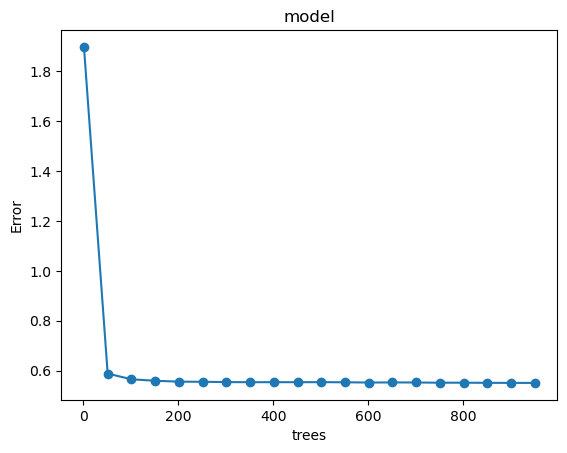

In [82]:
# Importieren von Modulen/Bibliotheken
import matplotlib.pyplot as plt

# Plotten der error-Werte in Abhängigkeit der Anzahl der Bäume des Random Forests, um optimalen n_estimators-Wert festzulegen
plt.plot(n_estimators_range, oob_error, marker="o")
plt.xlabel("trees")
plt.ylabel("Error")
plt.title("model")
plt.show()

As shown in the figure, the mean squared residuals stabilize around **500 trees**. Thus, in the following step we use `n_estimators=500` and optimize the tree depth.

### Hyper-parameter Tuning

To look at the available hyperparameters, we can examine the default values of our random forest model.

In [83]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 951,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 196,
 'verbose': 0,
 'warm_start': False}

That is quite a long list! How do we know where to start? A good place is the documentation on the random forest in Scikit-Learn. This tells us the most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features). 

* **n_estimators** = number of trees in the foreset
* **max_features** = max number of features considered for splitting a node
* **max_depth** = max number of levels in each decision tree
* **min_samples_split** = min number of data points placed in a node before the node is split
* **min_samples_leaf** = min number of data points allowed in a leaf node
* **bootstrap** = method for sampling data points (with or without replacement)

We could go read the research papers on the random forest and try to theorize the best hyperparameters, but a more efficient use of our time is just to try out a wide range of values and see what works! 


#### max_features
Now, we will tune the parameter that determines the number of variables that are randomly sampled as candidates at each split (max_features). The numbers of trees and variables are crucial for the model performance. We apply a range of **max_features from 1 to 5** while n_estimators is fixed at **500**. This grid represents different combinations of hyper-parameters to be tested. 

In [86]:
# Importieren von Modulen/Bibliotheken
import numpy as np

# Initialwert und Anzahl der Bäume für den Random Forest festlegen und Zufallszahlengenerator laufen lassen
seed = 196
n_estimators = 500
np.random.seed(seed)

# Hyperparameteroptimierung für das Modell durchführen und Identifikation der besten Modelle (bzgl. OOB-RMSE)
max_features_range = list(range(1, 5, 1))
hyper_grid = {
    "max_features": max_features_range,
    "n_estimators": [n_estimators] * len(max_features_range),
    "OOB_RMSE": [0] * len(max_features_range),
}

for i, params in enumerate(max_features_range):
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=params,
        oob_score=True,
        random_state=seed,
    )
    model.fit(X, y)
    hyper_grid["OOB_RMSE"][i] = model.oob_score_

hyper_grid_df = pd.DataFrame(hyper_grid)
hyper_grid_df = hyper_grid_df.sort_values(by="OOB_RMSE")  # .head(10)

In [87]:
hyper_grid_df

,max_features,n_estimators,OOB_RMSE
0,1,500,0.432123
1,2,500,0.450079
3,4,500,0.455360
2,3,500,0.455568


For each parameter combination, the [Out-of-Bag](https://en.wikipedia.org/wiki/Out-of-bag_error) (OOB) error is calculated. The best model with <font color='royalblue'>500 trees</font> has an <font color='royalblue'>max_features value of 1 (OOB_RMSE: 0.432123).</font> 

### Final Model

Now, the final RF model with optimized parameters can be created. The varimp() function is used to calculate the importance of each variable in the model. This tells us which variables are most predictive of O18.

In [88]:
# Importieren von Modulen/Bibliotheken
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Initialwert und Anzahl der Bäume für den Random Forest festlegen und Zufallszahlengenerator laufen lassen
seed = 196
n_estimators = 500
np.random.seed(seed)

In [89]:
# Optimalen max_features-Wert finden (Anzahl der zu betrachtenden, zufällig ausgewählten Features für jeden Baum)
min_idx = np.argmin(hyper_grid["OOB_RMSE"])
max_features = hyper_grid["max_features"][min_idx]

In [90]:
# Finales RandomForest erstellen und trainieren
model = RandomForestRegressor(
    n_estimators=n_estimators, max_features=max_features, random_state=seed
)
model.fit(X, y)

RandomForestRegressor(max_features=1, n_estimators=500, random_state=196)

In [91]:
# Statistiken über das Modell ausgeben lassen und die 10 wichtigsten Variablen extrahieren
stats = model.get_params()
feature_importance = model.feature_importances_
features = X.columns
var_imp_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})
var_imp_df = var_imp_df.sort_values(by="Importance", ascending=False).head(54)
var_imp_10 = var_imp_df.head(10)

In [92]:
# RMSE (Root Mean Square Error) und R² (R-squared) für Bewertung des Modells extrahieren
y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

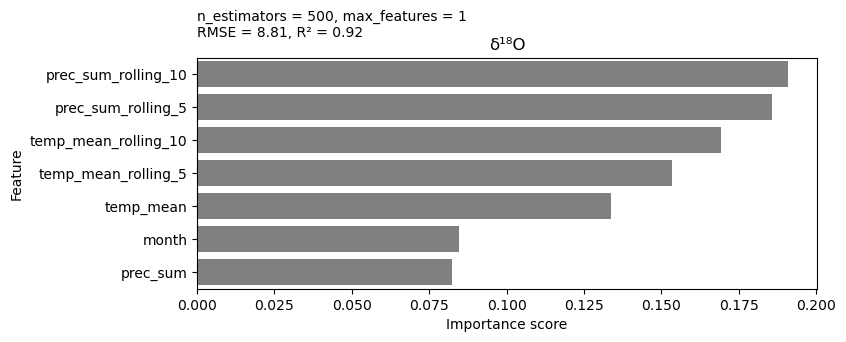

In [93]:
# Plotten der wichtigsten Variablen
plt.figure(figsize=(8, 3))
sns.barplot(x="Importance", y="Feature", data=var_imp_10, color="gray")
plt.title("δ¹⁸O")
plt.xlabel("Importance score")
plt.ylabel("Feature")
plt.text(
    0,
    -1.5,
    f"n_estimators = {n_estimators}, max_features = {max_features}\nRMSE = {rmse:.2f}, R² = {r2:.2f}",
    fontsize=10,
    ha="left",
    va="center",
)
plt.show()



For predicting the water level, <font color='royalblue'>the precipitation over the past 10 days</font> at sampling site seems to be the most important variable, among <font color='royalblue'>the precipitation over the past 5 days</font>, and the general location temperature.

---



#### Ressources for this script: 

* [Koehrsen 2010](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)


In [94]:
from IPython.display import IFrame

IFrame(
    src="../../citations/citation_marie.html",
    width=900,
    height=200,
)